In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_log_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-01 08:53:16.520665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746089596.910369      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746089597.010174      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    metric = root_mean_squared_log_error
    target = "Calories"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = pd.get_dummies(train, columns=["Sex"])
test = pd.get_dummies(test, columns=["Sex"])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [5]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.640712
Body_Temp,1.122022
Heart_Rate,0.978673
Age,0.097134
Height,0.056504
Weight,0.056289
Sex_male,0.016809
Sex_female,0.016040


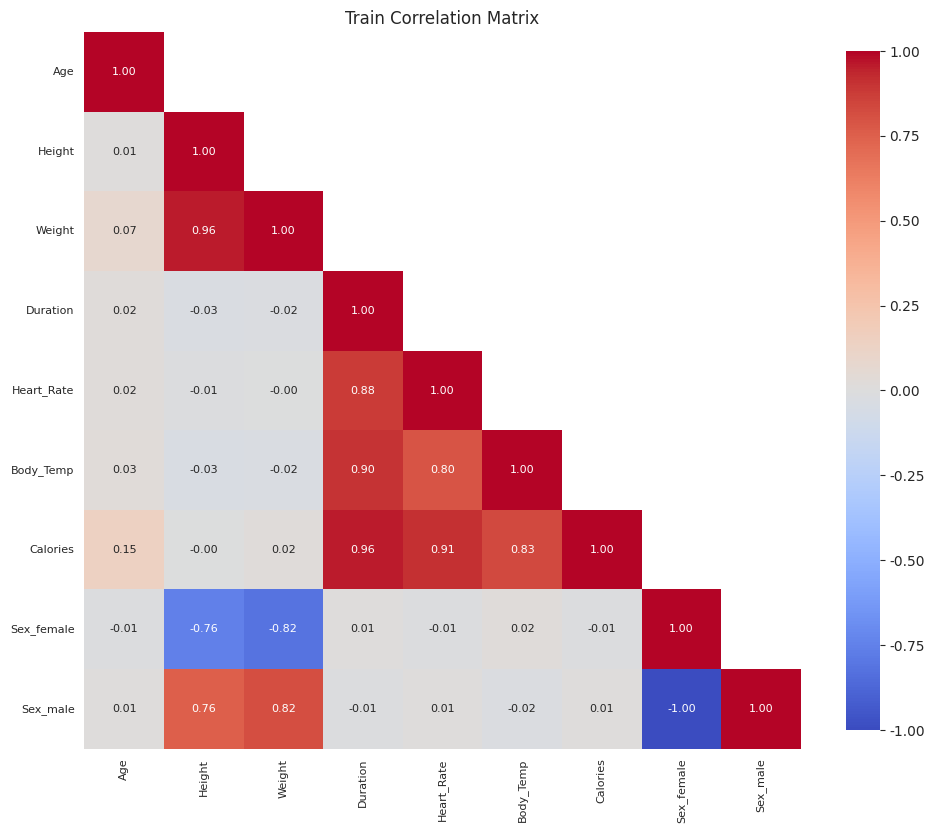

In [6]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 10))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)

ax.set_title('Train Correlation Matrix')
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

# Training base models

In [7]:
histgb_params = {
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [8]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [9]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0610 - Time: 182.18 s
--- Fold 1 - root_mean_squared_log_error: 0.0616 - Time: 167.69 s
--- Fold 2 - root_mean_squared_log_error: 0.0608 - Time: 191.77 s
--- Fold 3 - root_mean_squared_log_error: 0.0621 - Time: 175.76 s
--- Fold 4 - root_mean_squared_log_error: 0.0609 - Time: 180.83 s

------ Overall root_mean_squared_log_error: 0.0613 - Mean root_mean_squared_log_error: 0.0613 ± 0.0005 - Time: 900.37 s


## LightGBM (gbdt)

In [10]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.68917	valid_0's l2: 13.6099
[1000]	valid_0's rmse: 3.59052	valid_0's l2: 12.8918
[1500]	valid_0's rmse: 3.57998	valid_0's l2: 12.8163
Early stopping, best iteration is:
[1459]	valid_0's rmse: 3.57961	valid_0's l2: 12.8136
--- Fold 0 - root_mean_squared_log_error: 0.0630 - Time: 63.93 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.74369	valid_0's l2: 14.0152
[1000]	valid_0's rmse: 3.64049	valid_0's l2: 13.2532
Early stopping, best iteration is:
[1334]	valid_0's rmse: 3.63397	valid_0's l2: 13.2057
--- Fold 1 - root_mean_squared_log_error: 0.0637 - Time: 58.76 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.69722	valid_0's l2: 13.6694
[1000]	valid_0's rmse: 3.58717	valid_0's l2: 12.8678
Early stopping, best iteration is:
[1330]	valid_0's rmse: 3.57881	valid_0's l2: 12.8079
--- Fold 2 - root_mean_squ

## LightGBM (goss)

In [11]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 4.06984	valid_0's l2: 16.5636
[1000]	valid_0's rmse: 3.65283	valid_0's l2: 13.3431
[1500]	valid_0's rmse: 3.59207	valid_0's l2: 12.903
[2000]	valid_0's rmse: 3.57827	valid_0's l2: 12.804
[2500]	valid_0's rmse: 3.5742	valid_0's l2: 12.7749
Early stopping, best iteration is:
[2437]	valid_0's rmse: 3.57393	valid_0's l2: 12.773
--- Fold 0 - root_mean_squared_log_error: 0.0629 - Time: 152.09 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 4.12554	valid_0's l2: 17.0201
[1000]	valid_0's rmse: 3.70652	valid_0's l2: 13.7383
[1500]	valid_0's rmse: 3.64828	valid_0's l2: 13.31
[2000]	valid_0's rmse: 3.63576	valid_0's l2: 13.2187
[2500]	valid_0's rmse: 3.63146	valid_0's l2: 13.1875
Early stopping, best iteration is:
[2487]	valid_0's rmse: 3.63131	valid_0's l2: 13.1864
--- Fold 1 - root_mean_squared_log_error: 0.0634 - Time: 156.05 s

Training until valid

## XGBoost

In [12]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500
}

xgb_trainer.fit(X, y, fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:60.46275
[500]	validation_0-rmse:4.31327
[1000]	validation_0-rmse:3.79500
[1500]	validation_0-rmse:3.68366
[2000]	validation_0-rmse:3.64937
[2500]	validation_0-rmse:3.63668
[3000]	validation_0-rmse:3.62759
[3500]	validation_0-rmse:3.62096
[4000]	validation_0-rmse:3.61769
[4500]	validation_0-rmse:3.61513
[5000]	validation_0-rmse:3.61233
[5500]	validation_0-rmse:3.61108
[6000]	validation_0-rmse:3.61061
[6500]	validation_0-rmse:3.60992
[7000]	validation_0-rmse:3.60955
[7267]	validation_0-rmse:3.60914
--- Fold 0 - root_mean_squared_log_error: 0.0638 - Time: 314.62 s

[0]	validation_0-rmse:60.55821
[500]	validation_0-rmse:4.34605
[1000]	validation_0-rmse:3.89895
[1500]	validation_0-rmse:3.77782
[2000]	validation_0-rmse:3.73711
[2500]	validation_0-rmse:3.71525
[3000]	validation_0-rmse:3.70643
[3500]	validation_0-rmse:3.70014
[4000]	validation_0-rmse:3.69444
[4500]	validation_0-rmse:3.69102
[5000]	validation_0-rmse:3.68831
[5500]	validation_0-rmse:

## CatBoost

In [13]:
X_cb = X.copy()
X_test_cb = X_test.copy()

for col in X.columns.tolist():
    X_cb[f"{col}_cat"] = X[col].astype(str).astype("category")
    X_test_cb[f"{col}_cat"] = X_test[col].astype(str).astype("category")

cat_cols = [f + "_cat" for f in X.columns.tolist()]

In [14]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params, cat_features=cat_cols),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X_cb, y, fit_args)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test_cb)

Training CatBoostRegressor

0:	learn: 59.5382887	test: 59.3680389	best: 59.3680389 (0)	total: 739ms	remaining: 1h 1m 35s
500:	learn: 3.3285891	test: 3.5521158	best: 3.5519622 (499)	total: 5m 51s	remaining: 52m 33s
1000:	learn: 3.2002093	test: 3.5397440	best: 3.5393984 (943)	total: 12m 3s	remaining: 48m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.53887922
bestIteration = 1037

Shrink model to first 1038 iterations.
--- Fold 0 - root_mean_squared_log_error: 0.0605 - Time: 837.04 s

0:	learn: 59.4964051	test: 59.5458698	best: 59.5458698 (0)	total: 570ms	remaining: 47m 29s
500:	learn: 3.3221075	test: 3.5988879	best: 3.5988879 (500)	total: 5m 50s	remaining: 52m 26s
1000:	learn: 3.1931975	test: 3.5842724	best: 3.5839947 (986)	total: 12m 4s	remaining: 48m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.583644068
bestIteration = 1109

Shrink model to first 1110 iterations.
--- Fold 1 - root_mean_squared_log_error: 0.0608 - Time: 895.95 s

0

## Yggdrasil

In [15]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [16]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0621 - Time: 128.34 s
--- Fold 1 - root_mean_squared_log_error: 0.0619 - Time: 183.78 s
--- Fold 2 - root_mean_squared_log_error: 0.0621 - Time: 97.42 s
--- Fold 3 - root_mean_squared_log_error: 0.0637 - Time: 234.10 s
--- Fold 4 - root_mean_squared_log_error: 0.0626 - Time: 120.77 s

------ Overall root_mean_squared_log_error: 0.0625 - Mean root_mean_squared_log_error: 0.0625 ± 0.0006 - Time: 766.64 s


## Neural networks

In [17]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = pd.get_dummies(train, columns=["Sex"])
test = pd.get_dummies(test, columns=["Sex"])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [18]:
scaler = StandardScaler().set_output(transform="pandas")

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [19]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [20]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

2025-05-01 11:33:08.034099: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=5,
    random_state=CFG.seed,
)

In [22]:
nn_trainer = Trainer(
    nn_bag,
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_log_error,
    task="regression"
)

nn_trainer.fit(X, y)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor



2025-05-01 11:33:08.875846: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 11:33:15.147589: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_log_error: 0.0611 - Time: 746.52 s


2025-05-01 11:45:35.857200: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 11:45:42.040888: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_log_error: 0.0628 - Time: 561.45 s


2025-05-01 11:54:57.919431: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 11:55:03.774982: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_log_error: 0.0621 - Time: 595.95 s


2025-05-01 12:04:54.640044: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:05:00.564121: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_log_error: 0.0620 - Time: 799.20 s


2025-05-01 12:18:21.375169: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:21:21.804202: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_log_error: 0.0611 - Time: 784.51 s

------ Overall root_mean_squared_log_error: 0.0618 - Mean root_mean_squared_log_error: 0.0618 ± 0.0007 - Time: 3491.73 s


2025-05-01 12:31:20.069437: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 12:31:25.168053: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Ensembling with Ridge

In [23]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [24]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [25]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-01 12:32:02,788] A new study created in memory with name: no-name-50e842b5-f359-4ef9-9300-12a72d39b331
[I 2025-05-01 12:32:21,899] Trial 1 finished with value: 0.06021372154194561 and parameters: {'alpha': 0.8761434602311702, 'tol': 0.004074040233107818}. Best is trial 1 with value: 0.06021372154194561.
[I 2025-05-01 12:32:21,911] Trial 2 finished with value: 0.06021372139073503 and parameters: {'alpha': 1.6766483011004174, 'tol': 0.0020618949071524438}. Best is trial 2 with value: 0.06021372139073503.
[I 2025-05-01 12:32:21,913] Trial 0 finished with value: 0.06021372080640926 and parameters: {'alpha': 4.771097772232059, 'tol': 0.004190500325811632}. Best is trial 0 with value: 0.06021372080640926.
[I 2025-05-01 12:32:21,915] Trial 3 finished with value: 0.0602137208276238 and parameters: {'alpha': 4.658726969326214, 'tol': 0.0020007753653906277}. Best is trial 0 with value: 0.06021372080640926.
[I 2025-05-01 12:32:41,811] Trial 6 finished with value: 0.060213721223155714 a

In [26]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.999306800728691,
  "tol": 0.0063510698401865445
}


In [27]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - root_mean_squared_log_error: 0.0598 - Time: 0.15 s
--- Fold 1 - root_mean_squared_log_error: 0.0606 - Time: 0.14 s
--- Fold 2 - root_mean_squared_log_error: 0.0597 - Time: 0.14 s
--- Fold 3 - root_mean_squared_log_error: 0.0610 - Time: 0.13 s
--- Fold 4 - root_mean_squared_log_error: 0.0599 - Time: 0.19 s

------ Overall root_mean_squared_log_error: 0.0602 - Mean root_mean_squared_log_error: 0.0602 ± 0.0005 - Time: 6.52 s


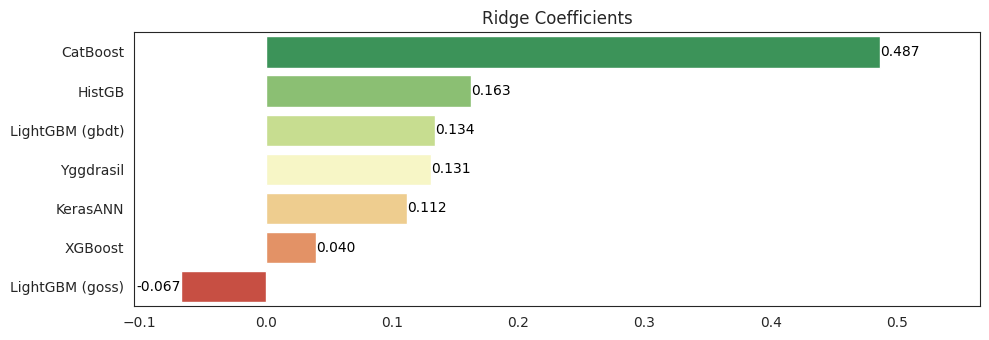

In [28]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [29]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.135743
1,750001,108.254707
2,750002,86.944837
3,750003,125.590980
4,750004,76.179024


# Results

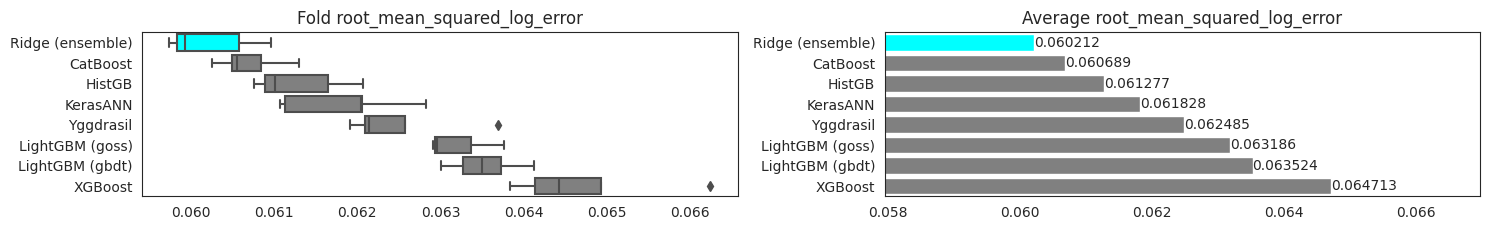

In [30]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()